In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import trfp

central_time = pytz.timezone('US/Central')

matplotlib.rc('xtick', labelsize=10)     
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', labelsize=12)
plt.rcParams["font.family"] = "serif"

# sns.set(style="darkgrid")
# sns.set(rc={'figure.figsize':(7,4.33)})

Welcome to JupyROOT 6.12/04


In [2]:
# # Load in the trolley run in question and remove trolley image
# tr3956 = trfp.TrolleyRun(3956)
# corrected_new_df = trfp.remove_trolley_effect(tr3956)

corrected_df = pd.read_hdf('run3956.h5', key='corrected_df')
tr3956_interp_df = pd.read_hdf('run3956.h5', key='tr3956_interp_df')
tr3956_moment_df = pd.read_hdf('run3956.h5', key='tr3956_moment_df')

In [3]:
## Boxcar averaging
# First find edges of "station regions"

station_phi = trfp.STATION_BARCODE_PHI
station_edges = trfp.STATION_BARCODE_EDGES

print len(station_edges)
# station_edges = (station_phi+np.roll(station_phi,1))/2
# if station_edges[3] >= 180.:  # accounts for wrap around at station 3
#     station_edges[3] = station_edges[3]-180.
# else:
#     station_edges[3] = station_edges[3]+180.

# station_extent = np.roll(station_edges,-1)-np.roll(station_edges,0)
# station_extent[2] = station_extent[2]+360

# # print station_extent
# # print station_edges

# station_edges = np.append(station_edges, station_edges[0])  # prevent array wrapping issues

# need to add column to corrected_df that includes "azimuthal extent" of a trolley measurement
# should be (tr_phi[x+1] - tr_phi[x-1])/2

# tr_phi is not monotonic, so sort by tr_phi

# corrected_df = corrected_df.sort_values(by=['tr_phi'])

# measured_phi = corrected_df['tr_phi'].values
# measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
# measured_extent[0] = measured_extent[0]+180
# measured_extent[-1] = measured_extent[-1]+180
# # print np.max(measured_extent)

# corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
# corrected_df = corrected_df.sort_index()

73


In [4]:
def trolley_run_station_average(corrected_df):
    station_phi = trfp.STATION_BARCODE_PHI
    station_edges = trfp.STATION_BARCODE_EDGES

    # tr_phi is not monotonic, so sort by tr_phi

    corrected_df = corrected_df.sort_values(by=['tr_phi'])

    measured_phi = corrected_df['tr_phi'].values
    measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
    measured_extent[0] = measured_extent[0]+180
    measured_extent[-1] = measured_extent[-1]+180
    # print np.max(measured_extent)

    corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
    corrected_df = corrected_df.sort_index()

    # for a given station:
    # create a mask for when trolley is in [low edge, high edge)
    tr_baseline = np.empty([72,17])
    fp_baseline = np.empty([72,6])
    summed_azimuth = np.empty(72)
    summed_pts = np.empty(72)
    tr_baseline[:] = np.nan
    fp_baseline[:] = np.nan
    summed_azimuth[:] = np.nan
    summed_pts[:] = np.nan

    for st in range(72): 
        if station_edges[st+1] > station_edges[st]:
            mask = (corrected_df['tr_phi'] >= station_edges[st]) & (corrected_df['tr_phi'] < station_edges[st+1])
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= station_edges[st]) | (corrected_df['tr_phi'] < station_edges[st+1])

        out_df = corrected_df[mask]
        summed_pts[st] = out_df.shape[0]
        summed_azimuth[st] = sum(out_df['tr_extent'].values)

        for m in range(17):
            st_id = 'tr,m'+str(m+1)
            tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)
        for m in range(6):
            st_id = 'st'+str(st)+',m'+str(m+1)
            fp_baseline[st, m] = np.mean(out_df[st_id])
    
    return tr_baseline, fp_baseline, summed_azimuth, summed_pts

In [5]:
tr_baseline, fp_baseline, summed_azimuth, summed_pts = trolley_run_station_average(corrected_df)

In [ ]:
# for a given station:
# create a mask for when trolley is in [low edge, high edge)
tr_baseline = np.zeros([72,17])
fp_baseline = np.zeros([72,6])
summed_azimuth = np.zeros(72)
summed_pts = np.zeros(72)

for st in range(72): 
    if station_edges[st+1] > station_edges[st]:
        mask = (corrected_df['tr_phi'] >= station_edges[st]) & (corrected_df['tr_phi'] < station_edges[st+1])
    else:  # case where we go over the 360 deg line
        mask = (corrected_df['tr_phi'] >= station_edges[st]) | (corrected_df['tr_phi'] < station_edges[st+1])

    out_df = corrected_df[mask]
    summed_pts[st] = out_df.shape[0]
    summed_azimuth[st] = sum(out_df['tr_extent'].values)
    
    for m in range(17):
        st_id = 'tr,m'+str(m+1)
        tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)
    for m in range(6):
        st_id = 'st'+str(st)+',m'+str(m+1)
        fp_baseline[st, m] = np.mean(out_df[st_id])

tr,m1:
Naive means:
	Unweighted average of all trolley measurements: 838.7781
	Unweighted average of all station-trolley baselines: 838.4212
Better means:
	Weighted average of all station-trolley baselines with a posteri station extent: 838.5787


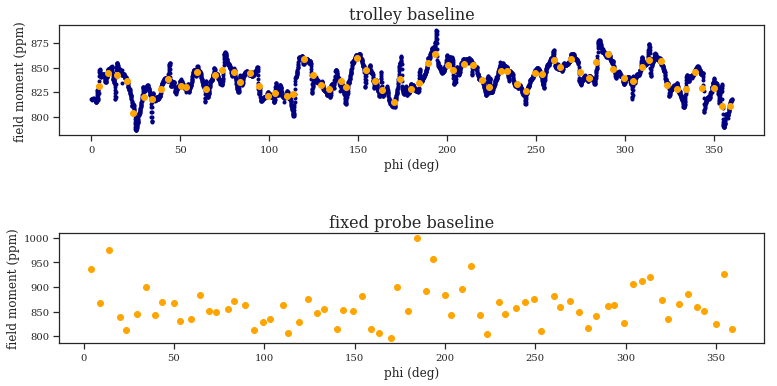

In [9]:
m = 1
trolley_moment = 'tr,m'+str(m)

fig1, ax1 = plt.subplots(2,1)
plt.sca(ax1[0])
plt.plot(corrected_df['tr_phi'],corrected_df[trolley_moment]/61.79, '.', color='navy')
plt.plot(station_phi, tr_baseline[:,m-1]/61.79, '.', color='orange', markersize=12)
ax1[0].set_xlabel('phi (deg)')
ax1[0].set_ylabel('field moment (ppm)')
ax1[0].set_title('trolley baseline')
plt.sca(ax1[1])
plt.plot(station_phi, fp_baseline[:,m-1]/61.79, '.', color='orange', markersize=12)
ax1[1].set_xlabel('phi (deg)')
ax1[1].set_ylabel('field moment (ppm)')
ax1[1].set_title('fixed probe baseline')

fig1.tight_layout()
fig1.set_size_inches(12,6)

print trolley_moment+':'
print 'Naive means:'
print '\tUnweighted average of all trolley measurements: %0.4f'%(np.mean(corrected_df[trolley_moment])/61.79)
print '\tUnweighted average of all station-trolley baselines: %0.4f'%(np.mean(tr_baseline[:,m-1])/61.79)

print 'Better means:'
# print '\tWeighted average of all trolley measurements: %0.4f'%sum((corrected_df['tr_extent'].values*corrected_df[trolley_moment].values)/sum(corrected_df['tr_extent'].values)/61.79)
# baseline_mean = sum(station_extent*tr_baseline[:,m-1])/sum(station_extent)
baseline_mean_2 = sum(summed_azimuth*tr_baseline[:,m-1])/sum(summed_azimuth)
print '\tWeighted average of all station-trolley baselines with a posteri station extent: %0.4f'%(baseline_mean_2/61.79)
# print '\tWeighted average of all station-trolley baselines with a priori station extent: %0.4f'%(baseline_mean/61.79)

# print summed_azimuth
# print station_extent
# plt.plot(summed_azimuth-station_extent)